In [1]:
from analysis_utils import main
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from package.orm_models import local_create_session, Result
from itertools import groupby
import sys
from collections import Counter
import pandas as pd
from package.orm_models import Result
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 9)

In [3]:
def std_show_results(args):
    sns.heatmap(main(args+['--confusion-matrix']), annot=True, fmt='.0f')
    main(args+['--plot-correlation'])

In [4]:
DATABASE = 'analysis16.db'
default_args = [
    '--db-file', DATABASE,
]

In [5]:
session = local_create_session(DATABASE)

In [ ]:
results = session.query(Result).all()
group_results = groupby(results, key=lambda x: list(map(str, x.args)))

for key, group in group_results:
    for arg in key:
        print(f'{arg}')
    results = list(group)
    selected_features = []
    for result in results:
        selected_features += result.selected_features
    selected_features = [feature.column for feature in selected_features]
    selected_features = dict(Counter(selected_features))
    selected_features = pd.DataFrame.from_dict(selected_features, orient='index', columns=['count'])
    selected_features = selected_features.sort_values(by='count', ascending=False)
    display(selected_features)
    
    args = default_args + ['--id'] + list(map(lambda x: str(x.id), results))
    std_show_results(args)
    print('-------------------------------------------------------------------------------------')
    sys.stdout.flush()

./datasets//CampusBasin/dataset.csv


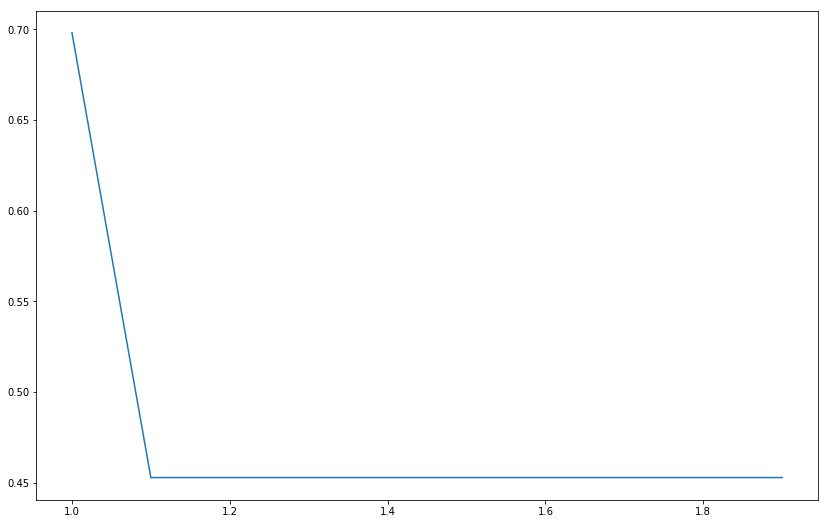

./datasets//MargemEquatorial/dataset.csv


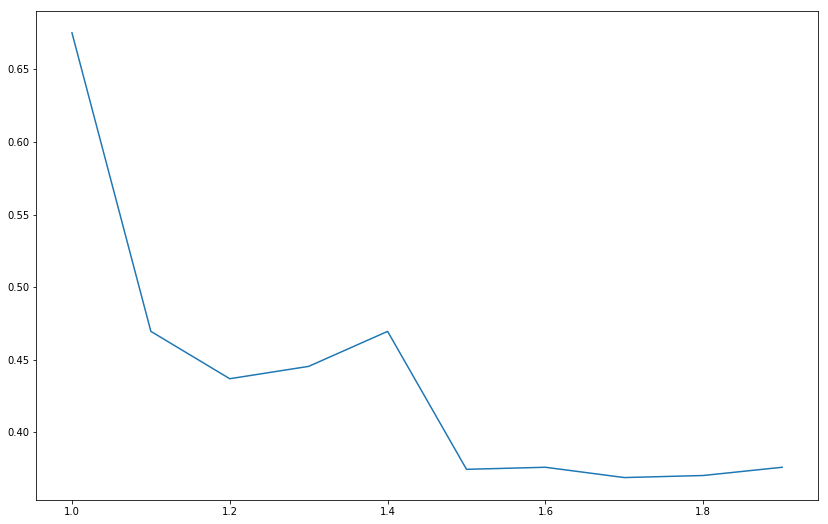

./datasets//TalaraBasin/dataset.csv


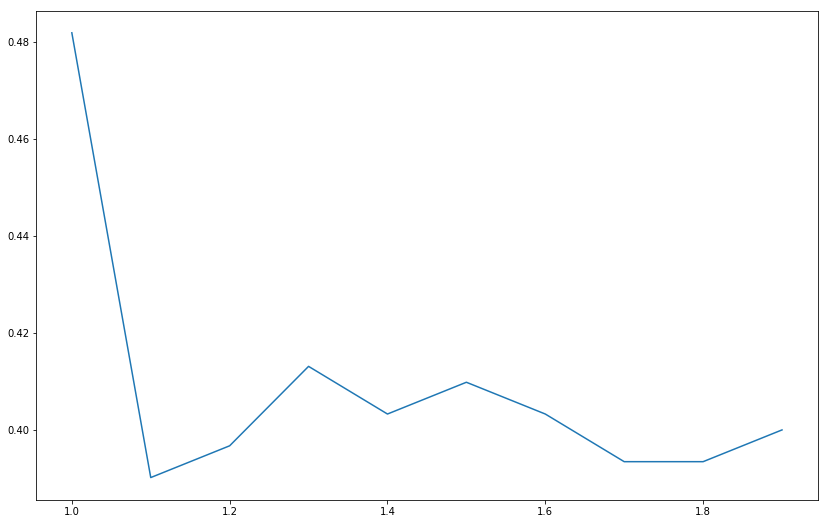

In [7]:
results = session.query(Result).all()
group_results = groupby(results, key=lambda x: [args.value for args in x.args if args.name == 'input_file'][0])
for dataset, group in group_results:
    x = []
    y = []
    print(dataset)
    group_betas = groupby(group, key=lambda x: [args.value for args in x.args if args.name == 'beta'][0])
    for beta, results_in in group_betas:
        x += [float(beta)]
        results_in = list(results_in)
        y += [np.mean([float(result.accuracy) for result in results_in])]
        
    plt.plot(x, y)
    plt.show()

In [8]:
session.close()